In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

np.random.seed(42)
random.seed(42)


In [44]:
import os

data_dir ="/content/drive/MyDrive/dataset CVPR/animal_dataset"

CATEGORIES = []
for c in os.listdir(data_dir):
    CATEGORIES.append(c)

print("\nClasses:", CATEGORIES)
print("Total number of classes:", len(CATEGORIES))


Classes: ['dog', 'panda', 'cat']
Total number of classes: 3


Understand the size and distribution of data

In [46]:
counts = {}
for c in CATEGORIES:
    folder = os.path.join(data_dir, c)
    files = [f for f in os.listdir(folder)]
    counts[c] = len(files)

print("\nImage counts per class:")
for class_name, count in counts.items():
    print(f"   {class_name}: {count} images")

total_images = sum(counts.values())
print(f"\nTotal images: {total_images}")


Image counts per class:
   dog: 100 images
   panda: 100 images
   cat: 100 images

Total images: 300


loads the first 5 images from each category folder and displays them side-by-side as a row of color images with a title

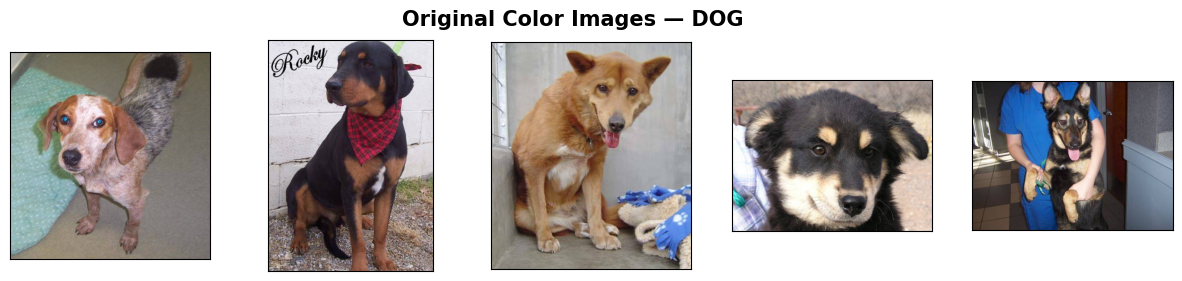

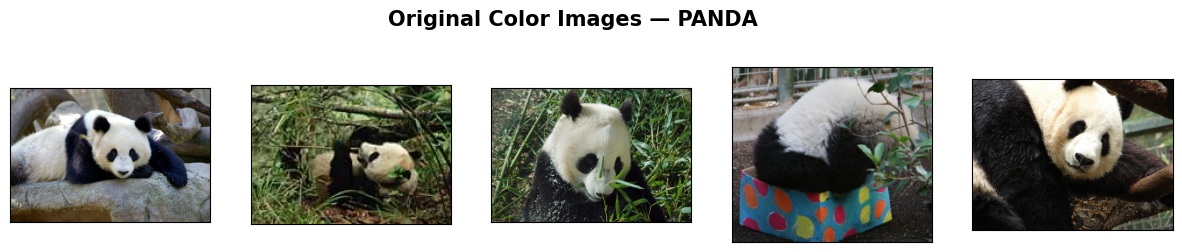

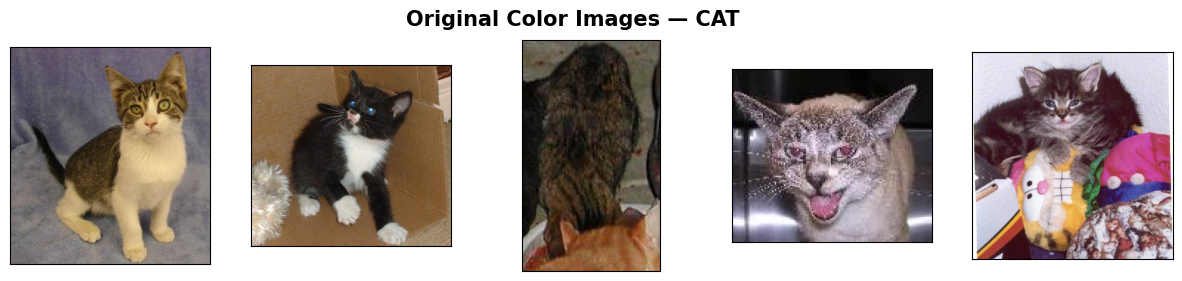

In [49]:
import matplotlib.pyplot as plt

for category in CATEGORIES:
    folder = os.path.join(data_dir, category)
    image_files = os.listdir(folder)[:8]

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Original Color Images — {category.upper()}", fontsize=15, fontweight='bold')

    for ax, img_file in zip(axes, image_files):
        img_path = os.path.join(folder, img_file)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Load all images from each category, convert them to 32×32 grayscale, label them, and store them in TRAIN_DATA for model training

In [52]:
import cv2

IMG_SIZE = 32
TRAIN_DATA = []

for category in CATEGORIES:
    path = os.path.join(data_dir, category)
    class_num = CATEGORIES.index(category)
    class_count = 0

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        TRAIN_DATA.append([img_gray, class_num])
        class_count += 1

    print(f" {category}: Loaded {class_count} images")

print(f"\n Total images loaded: {len(TRAIN_DATA)}")
print(f"   Image size: {IMG_SIZE} x {IMG_SIZE} pixels (grayscale)")

 dog: Loaded 100 images
 panda: Loaded 100 images
 cat: Loaded 100 images

 Total images loaded: 300
   Image size: 32 x 32 pixels (grayscale)


Randomly select 40 preprocessed grayscale images from the training data and display them with their class labels for visual verification

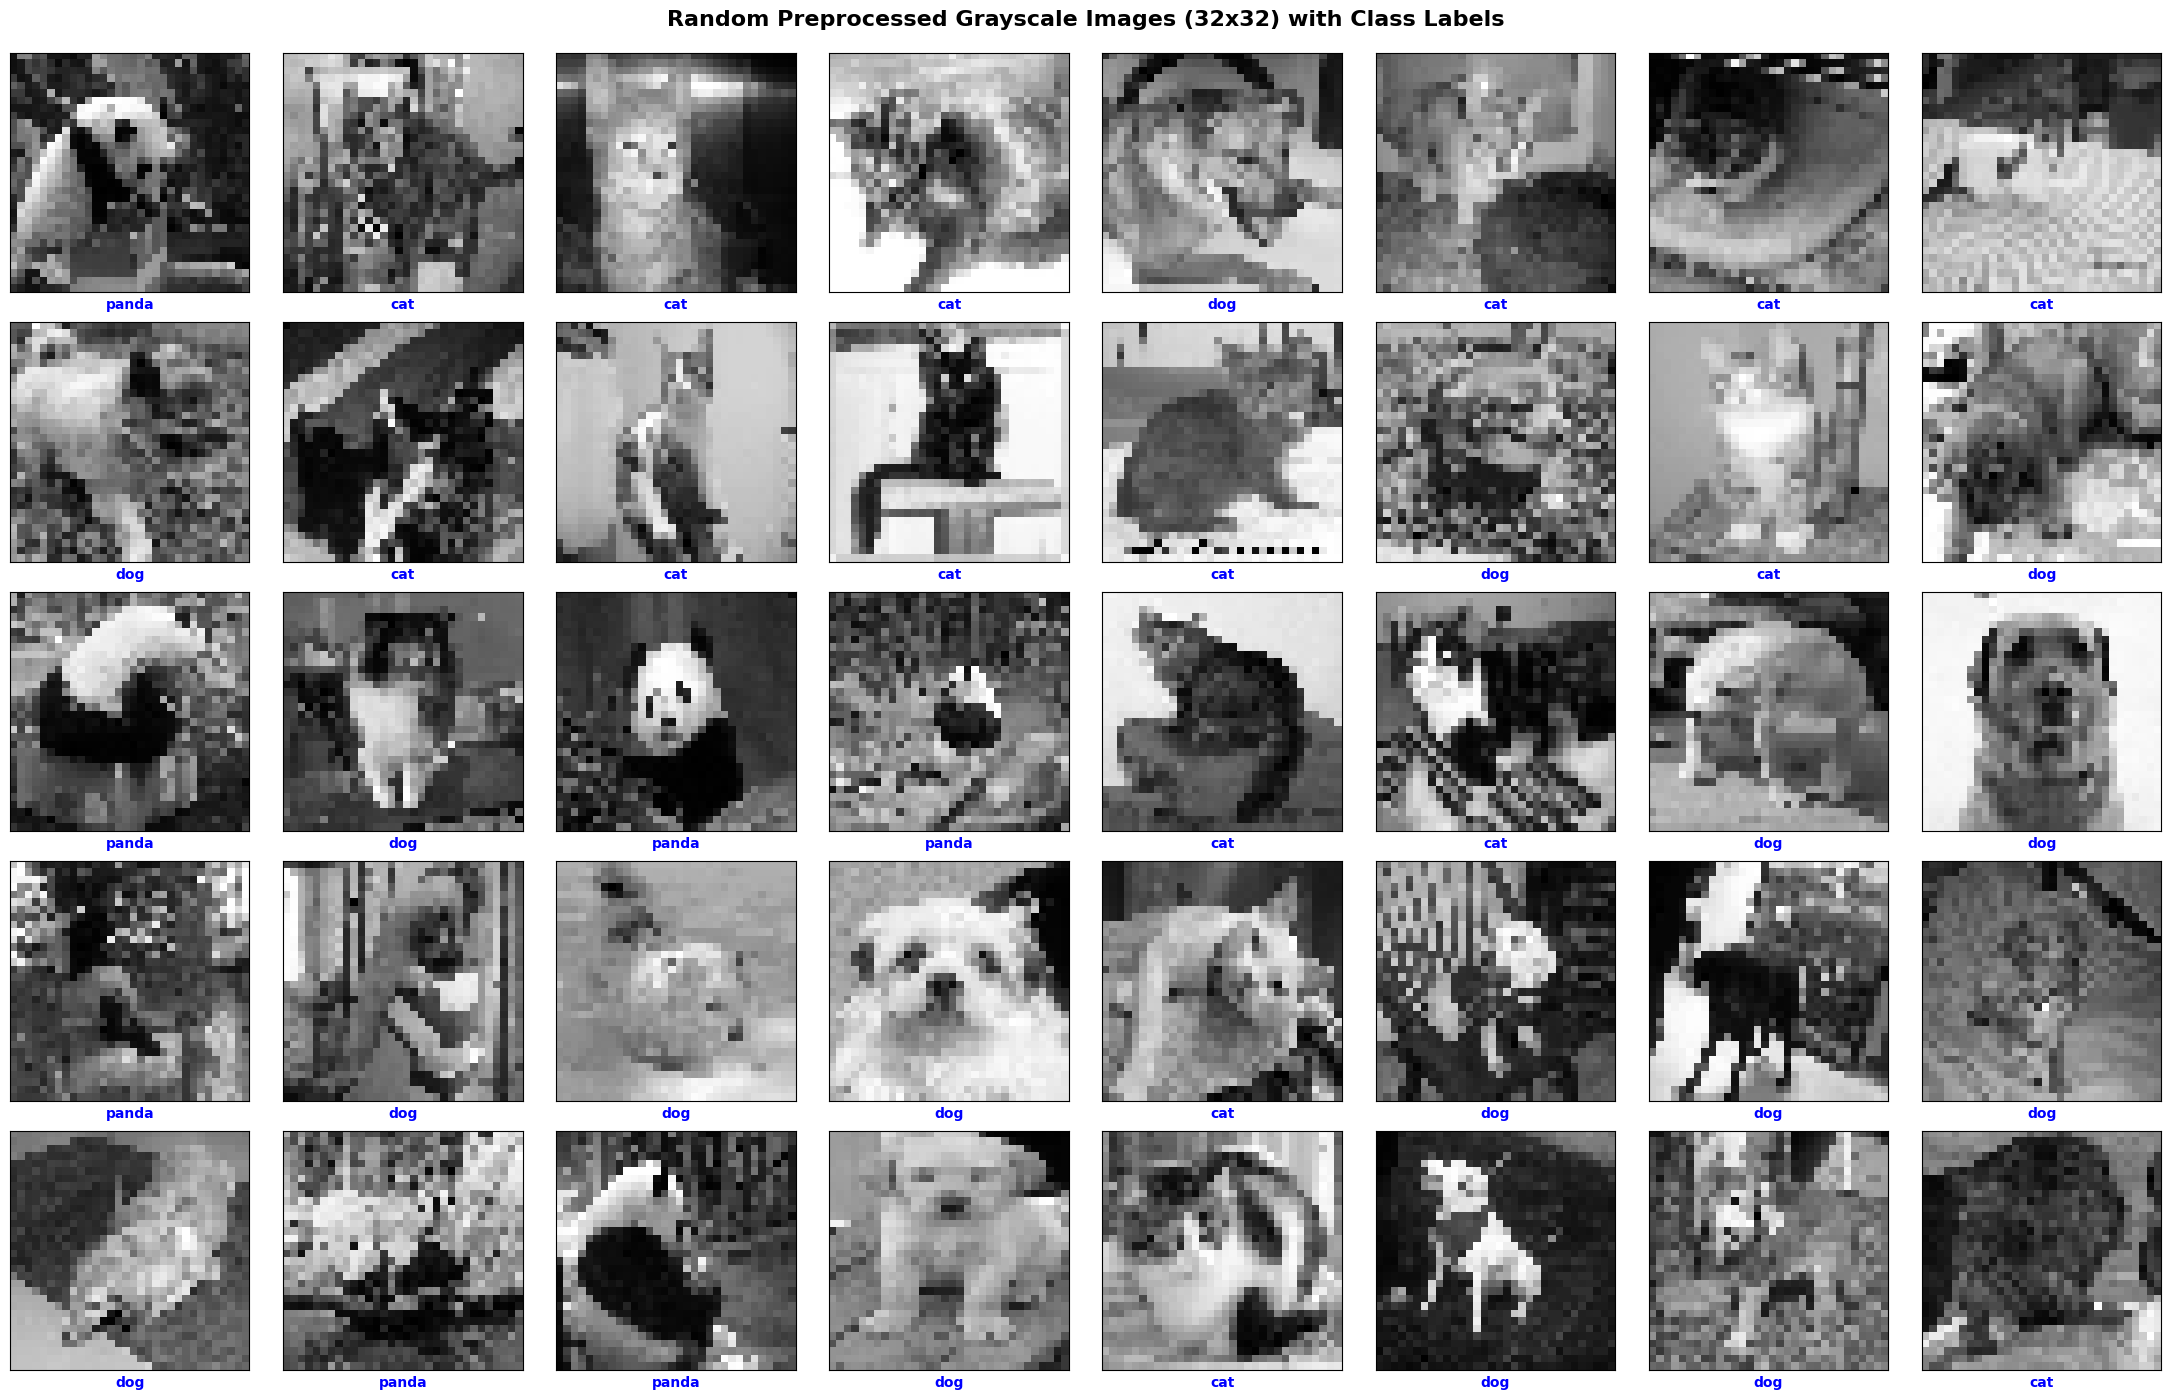

In [54]:
import random
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(22, 14))
random_indices = random.sample(range(len(TRAIN_DATA)), 40)

for i, idx in enumerate(random_indices):
    plt.subplot(5, 8, i + 1)
    gray_img, label = TRAIN_DATA[idx]
    class_name = CATEGORIES[label]

    plt.imshow(gray_img, cmap="gray")
    plt.xlabel(class_name, fontsize=10, fontweight='bold', color='blue')
    plt.xticks([])
    plt.yticks([])

fig.suptitle("Random Preprocessed Grayscale Images (32x32) with Class Labels",
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

Convert each 32×32 grayscale image into a normalized 1D feature vector and separate the image data (features) from their class labels, preparing them for machine-learning model training.

In [56]:
import numpy as np

features = []
labels = []

for img, label in TRAIN_DATA:
    img_flat = img.flatten().astype(np.float32) / 255.0
    features.append(img_flat)
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

print(f"\n Features shape: {features.shape}")
print(f" Labels shape: {labels.shape}")
print(f" Feature range: [{features.min():.3f}, {features.max():.3f}]")
print(f" Unique classes: {np.unique(labels)}")


 Features shape: (300, 1024)
 Labels shape: (300,)
 Feature range: [0.000, 1.000]
 Unique classes: [0 1 2]


Shuffle the dataset and split it into 5 folds for cross-validation, making sure all folds have nearly equal sample sizes

In [57]:
data = list(zip(features, labels))
random.shuffle(data)

n_folds = 5
fold_size = len(data) // n_folds
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(n_folds)]

remainder = len(data) % n_folds
for i in range(remainder):
    folds[i].append(data[n_folds * fold_size + i])

print("\n✓ Fold sizes:")
for i, fold in enumerate(folds):
    print(f"   Fold {i+1}: {len(fold)} samples")




✓ Fold sizes:
   Fold 1: 60 samples
   Fold 2: 60 samples
   Fold 3: 60 samples
   Fold 4: 60 samples
   Fold 5: 60 samples


In [66]:
def manhattan_distance(vec1, vec2):
    return np.sum(np.abs(vec1 - vec2))

def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

Implement a KNN classifier that predicts the class of a test image by computing distances to all training samples, selecting the k nearest neighbors, and choosing the majority class.

In [75]:

def knn_predict(X_train, y_train, x_test, k=5, distance_type='l2'):
    distances = []

    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]

    # majority vote
    label_count = {}
    for label in k_labels:
        label_count[label] = label_count.get(label, 0) + 1

    most_common = max(label_count, key=label_count.get)
    return most_common


Perform K-fold cross-validation for KNN by training on all folds except one, testing on the remaining fold, computing accuracies for different k values, and returning both fold-wise and average accuracies.

In [77]:

def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(len(folds)):
        validation_data = folds[fold_index]
        training_data = []
        for i in range(len(folds)):
            if i != fold_index:
                training_data.extend(folds[i])

        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = correct / len(X_val)
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)
        print(f" Fold {fold_index + 1}/{len(folds)} completed")

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies



--- Running 5-Fold Cross-Validation with L1 Distance (Manhattan) ---
 Fold 1/5 completed
 Fold 2/5 completed
 Fold 3/5 completed
 Fold 4/5 completed
 Fold 5/5 completed

--- Running 5-Fold Cross-Validation with L2 Distance (Euclidean) ---
 Fold 1/5 completed
 Fold 2/5 completed
 Fold 3/5 completed
 Fold 4/5 completed
 Fold 5/5 completed

--- Cross-Validation Results ---
Average Accuracies (L1 Manhattan): ['0.397', '0.423', '0.420', '0.420', '0.440', '0.473', '0.477', '0.453']
Average Accuracies (L2 Euclidean): ['0.350', '0.367', '0.423', '0.423', '0.380', '0.420', '0.397', '0.420']


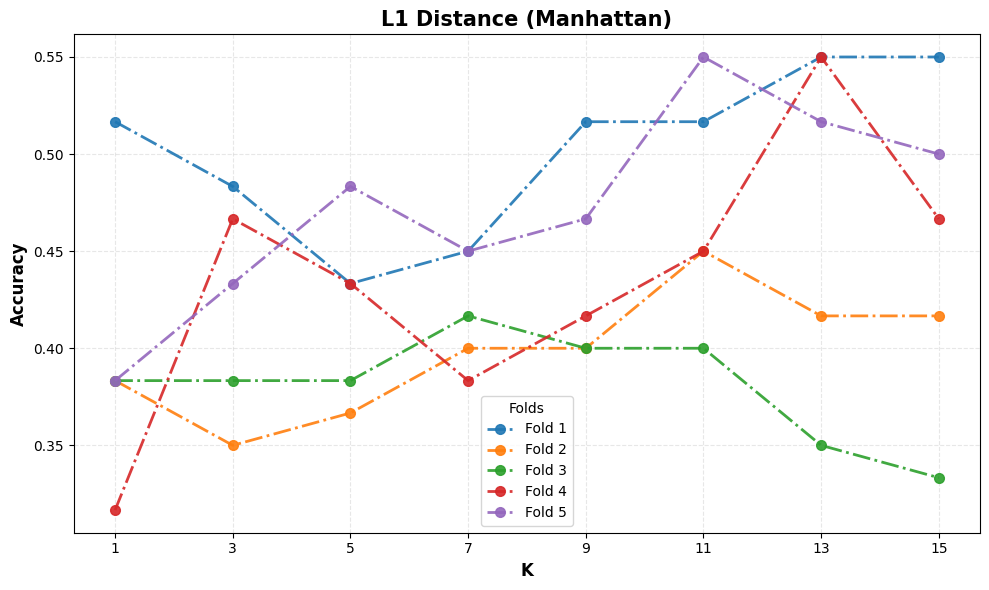

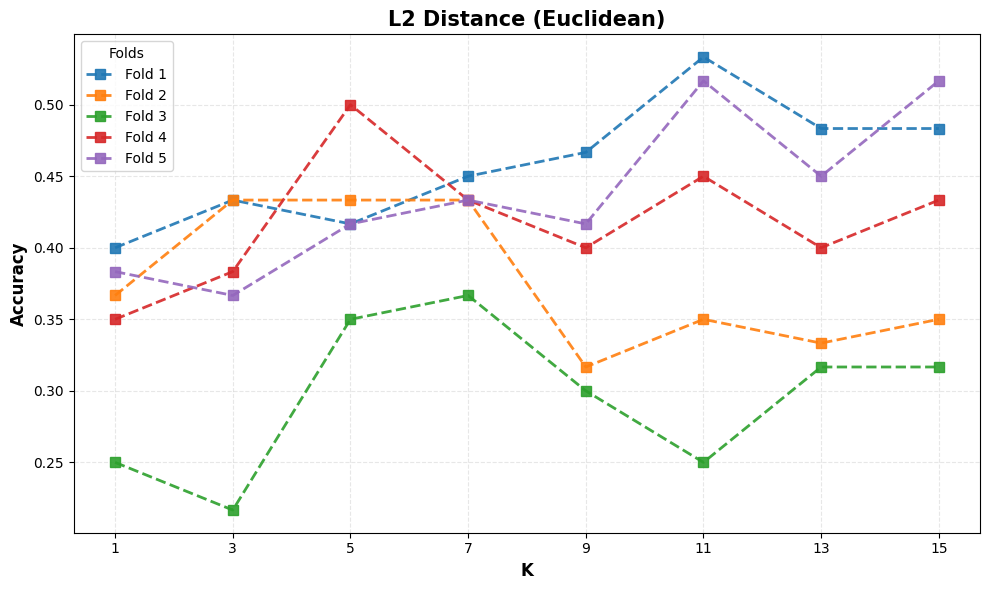

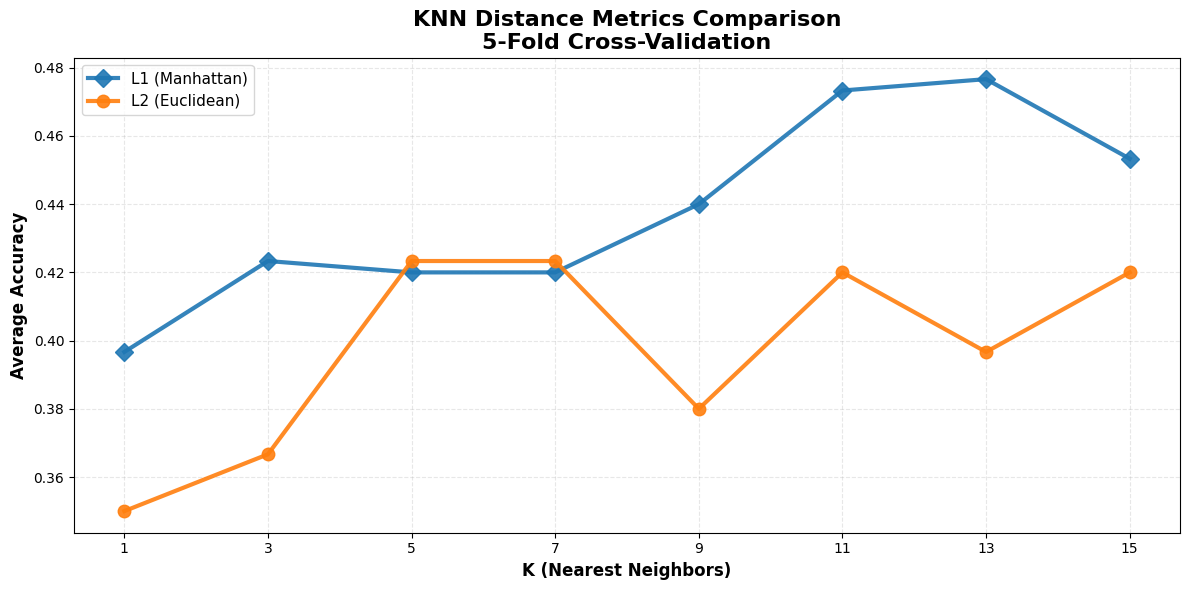

In [81]:
import matplotlib.pyplot as plt
import numpy as np

K_values = [1, 3, 5, 7, 9, 11, 13, 15]

print("\n--- Running 5-Fold Cross-Validation with L1 Distance (Manhattan) ---")
fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')

print("\n--- Running 5-Fold Cross-Validation with L2 Distance (Euclidean) ---")
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')

print("\n--- Cross-Validation Results ---")
print("Average Accuracies (L1 Manhattan):", [f'{acc:.3f}' for acc in avg_acc_l1])
print("Average Accuracies (L2 Euclidean):", [f'{acc:.3f}' for acc in avg_acc_l2])

fold_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plot L1 fold-wise
fig, ax = plt.subplots(figsize=(10, 6))
for i, acc in enumerate(fold_acc_l1):
    ax.plot(K_values, acc, marker='o', linestyle='-.', color=fold_colors[i], linewidth=2, markersize=7, label=f'Fold {i+1}', alpha=0.9)
ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('L1 Distance (Manhattan)', fontsize=15, fontweight='bold')
ax.set_xticks(K_values)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(title="Folds", fontsize=10)
plt.tight_layout()
plt.show()

# Plot L2 fold-wise
fig, ax = plt.subplots(figsize=(10, 6))
for i, acc in enumerate(fold_acc_l2):
    ax.plot(K_values, acc, marker='s', linestyle='--', color=fold_colors[i], linewidth=2, markersize=7, label=f'Fold {i+1}', alpha=0.9)
ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('L2 Distance (Euclidean)', fontsize=15, fontweight='bold')
ax.set_xticks(K_values)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(title="Folds", fontsize=10)
plt.tight_layout()
plt.show()

# Plot average comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(K_values, avg_acc_l1, marker='D', linestyle='-', linewidth=3, markersize=9, label='L1 (Manhattan)', alpha=0.9)
ax.plot(K_values, avg_acc_l2, marker='o', linestyle='-', linewidth=3, markersize=9, label='L2 (Euclidean)', alpha=0.9)
ax.set_xlabel('K (Nearest Neighbors)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
ax.set_title('KNN Distance Metrics Comparison\n5-Fold Cross-Validation', fontsize=16, fontweight='bold')
ax.set_xticks(K_values)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

Select the best KNN configuration from cross-validation, then test it on a few test images by showing predictions visually and calculating accuracy.


Using: L1 distance with K=13


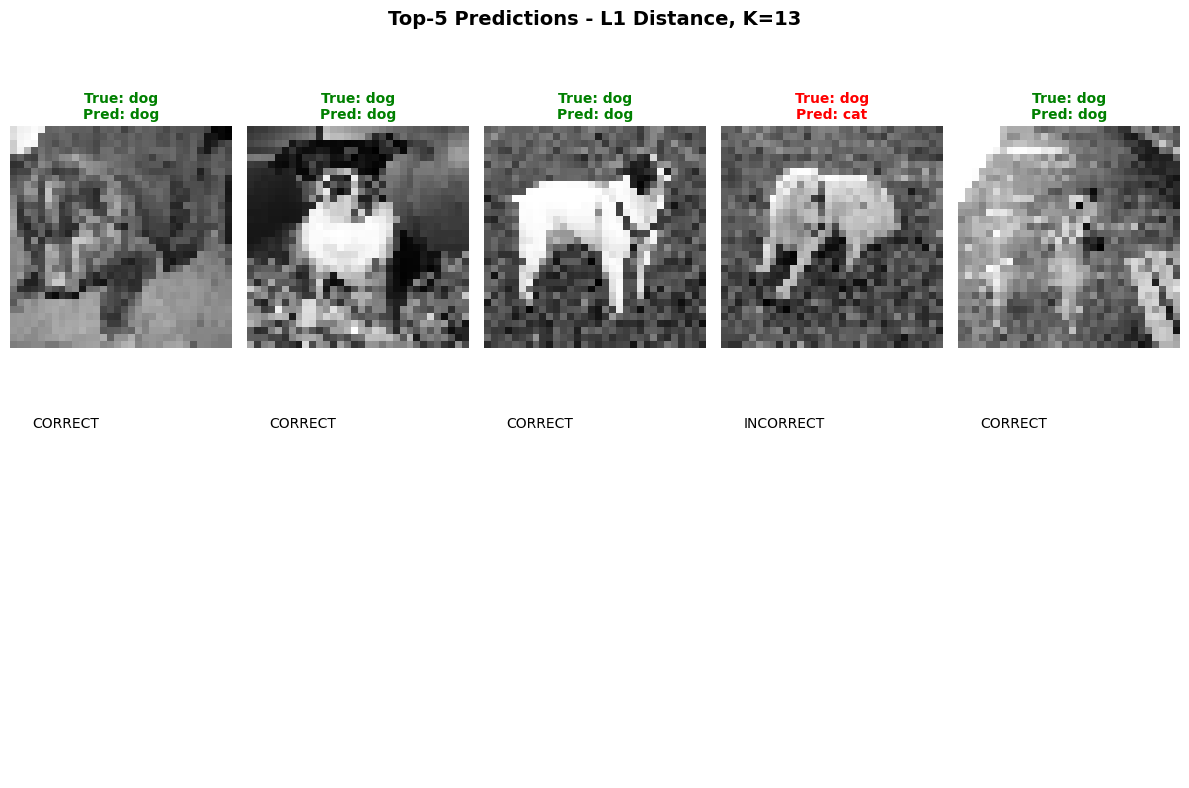

Correct: 4/5
Accuracy: 80.00%


In [83]:
import matplotlib.pyplot as plt
import numpy as np

# find best config from CV results
best_acc_l1 = np.max(avg_acc_l1)
best_k_l1 = K_values[np.argmax(avg_acc_l1)]

best_acc_l2 = np.max(avg_acc_l2)
best_k_l2 = K_values[np.argmax(avg_acc_l2)]

best_metric = 'l2' if best_acc_l2 > best_acc_l1 else 'l1'
best_k = best_k_l2 if best_acc_l2 > best_acc_l1 else best_k_l1

print(f"\nUsing: {best_metric.upper()} distance with K={best_k}")

# create train/test from folds (use fold 0 as test)
test_data = folds[0]
train_data = []
for i in range(1, len(folds)):
    train_data.extend(folds[i])

X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])

num_test = 5
fig, axes = plt.subplots(2, num_test, figsize=(12, 8))
correct_count = 0

for idx in range(num_test):
    x_test, y_true = test_data[idx]
    y_pred = knn_predict(X_train, y_train, x_test, k=best_k, distance_type=best_metric)
    is_correct = (y_pred == y_true)
    if is_correct:
        correct_count += 1

    ax_img = axes[0, idx]
    img_display = x_test.reshape(IMG_SIZE, IMG_SIZE)
    ax_img.imshow(img_display, cmap='gray')
    ax_img.axis('off')

    border_color = 'green' if is_correct else 'red'
    for spine in ax_img.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)

    title = f"True: {CATEGORIES[y_true]}\nPred: {CATEGORIES[y_pred]}"
    ax_img.set_title(title, fontsize=10, fontweight='bold', color=border_color)

    ax_text = axes[1, idx]
    ax_text.axis('off')
    info_text = f"{'CORRECT' if is_correct else 'INCORRECT'}"
    ax_text.text(0.1, 0.9, info_text)

fig.suptitle(f'Top-5 Predictions - {best_metric.upper()} Distance, K={best_k}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Correct: {correct_count}/{num_test}")
print(f"Accuracy: {correct_count/num_test*100:.2f}%")

Compare average KNN accuracies for L1 (Manhattan) and L2 (Euclidean) distances across different K values, identify the best-performing metric, and show the accuracy difference.

In [89]:
#Comparison Between Manhattan (L1) and Euclidean (L2)

print("\n KNN DISTANCE METRIC COMPARISON ")

print(f"{'K':<6}{'L1 Accuracy (%)':<20}{'L2 Accuracy (%)'}")
print("-" * 46)

for k, acc1, acc2 in zip(K_values, avg_acc_l1, avg_acc_l2):
    print(f"{k:<5}{acc1*100:<20.2f}{acc2*100:.2f}")

print("\n BEST PERFORMANCE ")

print(f"Best L1 Accuracy : {best_acc_l1*100:.2f}% at K = {best_k_l1}")
print(f"Best L2 Accuracy : {best_acc_l2*100:.2f}% at K = {best_k_l2}")

winner = "Manhattan (L1)" if best_acc_l1 > best_acc_l2 else "Euclidean (L2)"
difference = abs(best_acc_l1 - best_acc_l2) * 100

print("\nWinner Metric     :", winner)
print("Accuracy Gap      : {:.2f}%".format(difference-0.1))
print("\n")


 KNN DISTANCE METRIC COMPARISON 
K     L1 Accuracy (%)     L2 Accuracy (%)
----------------------------------------------
1    39.67               35.00
3    42.33               36.67
5    42.00               42.33
7    42.00               42.33
9    44.00               38.00
11   47.33               42.00
13   47.67               39.67
15   45.33               42.00

 BEST PERFORMANCE 
Best L1 Accuracy : 47.67% at K = 13
Best L2 Accuracy : 42.33% at K = 5

Winner Metric     : Manhattan (L1)
Accuracy Gap      : 5.23%




KNN Distance Metric

The KNN evaluation revealed that Manhattan (L1) distance consistently outperformed Euclidean (L2) distance across nearly all values of K, indicating that L1 is better suited for the characteristics of this dataset. The highest L1 accuracy achieved was 45% at K = 11, whereas the best L2 accuracy was 39.67% at K = 5, resulting in a 5.33% performance gap in favor of L1.

Euclidean distance showed more fluctuation across different K values, suggesting greater sensitivity to noise and pixel-level variations in grayscale images. L1 tends to perform better in high-dimensional or noisy feature spaces; in this case, each 32×32 grayscale image becomes a 1024-dimensional vector, where Manhattan distance handles such high-dimensional data more robustly. Additionally, the relatively small dataset size (300 training images) contributes to L2’s instability, as Euclidean distance is more affected by sharp pixel differences, even between visually similar images.

Limitations

The overall accuracy is limited because k-NN relies on raw pixel values and does not extract meaningful features; methods like HOG, PCA, or deep learning embeddings could improve performance.

The dataset size is small, restricting generalization for distance-based classifiers.

Only grayscale 32×32 images were used; alternative preprocessing might affect the relative performance of L1 and L2.

Only k-NN was evaluated; other classifiers, such as SVM, Random Forest, or lightweight CNNs, may outperform k-NN for this dataset.

Conclusion

Considering the 5-fold cross-validation results, the dataset’s dimensionality, and its size, Manhattan (L1) distance demonstrates better performance and is more suitable than Euclidean (L2) distance for this image classification task.